In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif

import motogp_module as gp

The main question is: What factors influence the decision to promote a Moto2 rider to MotoGP? Based on our data, we can create a binary classification with the dependent variable 'got_promoted' and independent variables such as the number of first, second, and third places; overall podium finishes; median position during the season; median time difference to the leader over all races; number of races completed in Moto2; and, of course, the amount of points earned during the season. The key question here is whether the amount of points, i.e., victory in the Moto2 championship, is the defining factor that determines whether a rider will move to the MotoGP category, or if factors such as the number of first places and overall consistency of results during the season are more important.

1.  Let's start by loading the data and restricting it to the relevant time frame, starting from the year 2000 and focusing on the current era, which began with Marc Marquez's decisive victory in the 2012 Moto2 season and subsequent promotion to MotoGP. We won't consider data from previous championships, as they were quite different and modern axioms don't apply to them. Including this data could introduce a lot of noise. However, we will include data from 2012 onwards to calculate the overall race count for all riders in the 2012 Moto2 season. This feature, race_count, should indicate how many races it took for a rider to become accustomed to the Moto2 category and start winning. In fact, before beginning the analysis, I would assume that a smaller number of races is a better metric for deciding if a rider deserves promotion to MotoGP. The fewer races it took to succeed, the better.

Additionally, we'll define a color palette and a function for tabs using notebook widgets to conveniently display all the data when choosing seasons.

All functions for creating and joining tables are defined in the 'motogp_module' file. Further explanations of all manipulations performed on the original dataset are provided there.

In [3]:
df = pd.read_csv(
    "/home/kuan/Documents/usb_recovery/python_files/Projects/data_analysis/motogp/FILTERED_ROWS.csv"
)

data = df[df["year"] > 2000]

sns.set_palette("tab10")

colors = sns.color_palette("tab10")


def create_tab_with_outputs(start_year, end_year):
    tab = widgets.Tab()
    outputs = []

    for year in range(start_year, end_year + 1):
        out = widgets.Output()
        outputs.append(out)
        tab.children += (out,)
        tab.set_title(len(outputs) - 1, str(year))

    return tab, outputs

2.  Let's start by creating visualization plots for the standings of the 2012-2020 Moto2 seasons based on the overall points obtained by all the riders. As we can see from the data, the highest amount of points doesn't necessarily lead to promotion.

In [5]:
tab, outputs = create_tab_with_outputs(2012, 2020)

for year, out in zip(range(2012, 2021), outputs):
    got_promoted = gp.gotPromotionToMotoGP(
        data=data, season_start=year, season_end=year + 1, riders_amount=10
    )

    conditions = got_promoted["got_promoted"] == 1
    labels = ["Promoted" if condition else "Not promoted" for condition in conditions]

    with out:
        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            data=got_promoted,
            y="rider_name",
            x="points",
            hue=labels,
            orient="h",
            ax=ax,
            dodge=False,
            palette={"Promoted": colors[4], "Not promoted": colors[0]},
            hue_order=["Promoted", "Not promoted"],
        )

        ax.set_title(f"{year} Moto2 Championship Standings")

        ax.bar_label(ax.containers[0], fontsize=9)
        ax.bar_label(ax.containers[1], fontsize=9)

        ax.legend()

        plt.show(fig)

display(tab)

As we can see from the bar plots, the number of riders who got promoted is not stable every season. Additionally, some riders who are way above the top 3 in the season somehow get promoted to MotoGP. Therefore, points alone don't determine who got promoted

3. Let's check the number of gold, silver, and bronze medals, i.e., victories, second places, and third places, and also include finishes with no points.

In [6]:
tab, outputs = create_tab_with_outputs(2012, 2020)

for year, out in zip(range(2012, 2021), outputs):
    riders_positions = gp.riderPositions(data, year=year, category="Moto2").sort_values(
        by="amount_of_1", ascending=False
    )

    riders_positions_long = riders_positions.head(5).melt(
        id_vars="rider_name", var_name="position", value_name="count"
    )

    mapping = {
        "amount_of_1": "Gold",
        "amount_of_2": "Silver",
        "amount_of_3": "Bronze",
        "amount_of_0_points": "No point finish",
    }
    riders_positions_long["position"] = riders_positions_long["position"].map(mapping)

    with out:
        plt.figure(figsize=(10, 8))
        sns.barplot(
            data=riders_positions_long,
            x="count",
            y="rider_name",
            hue="position",
            orient="h",
        )
        plt.title(f"{year} Moto2 Race Positions for Each Rider")
        plt.legend(title="Positions", loc="lower right")
        plt.show()

display(tab)

From the graph, we observe that some riders have achieved numerous podiums and victories, yet they've also experienced no-point finishes, indicating races where they finished below 15th place, often due to issues like crashes. This suggests that young riders may demonstrate exceptional speed, enabling them to win races, but they may also suffer from crashes due to their lack of experience. MotoGP teams may recognize that certain riders possess tremendous talent, evident from their victories and podium finishes, but also acknowledge their occasional crashes as a byproduct of inexperience.

Hence, we can hypothesize that the number of victories in races may hold greater significance for MotoGP teams than the amount of points during season if they prioritize raw talent over experience. Essentially, experience can be acquired over time, but talent is an innate quality. MotoGP teams may prioritize signing the fastest rider in terms of pure talent, rather than a rider who wins solely because they've spent numerous races in Moto2. This hypothesis is based on the notion that MotoGP teams seek riders who can immediately contend for victories upon entering MotoGP, rather than those who require extensive time in the midfield before achieving success.

Given that MotoGP teams typically offer two-season contracts to riders, this hypothesis holds weight, as riders in MotoGP have limited time for adaptation.

4. Let's check the median position during each season for each rider.

In [7]:
tab, outputs = create_tab_with_outputs(2012, 2020)

for year, out in zip(range(2012, 2021), outputs):
    got_promoted = gp.gotPromotionToMotoGP(
        data=data, season_start=year, season_end=year + 1, riders_amount=100
    )

    got_promoted = got_promoted[got_promoted["median_position"] > 0].head(10)

    got_promoted["rider_name"] = got_promoted["rider_name"].str.split("_").str[0]

    conditions = got_promoted["got_promoted"] == 1
    labels = ["Promoted" if condition else "Not promoted" for condition in conditions]

    with out:
        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            data=got_promoted,
            y="rider_name",
            x="median_position",
            hue=labels,
            orient="h",
            ax=ax,
            dodge=False,
            palette={"Promoted": colors[4], "Not promoted": colors[0]},
            hue_order=["Promoted", "Not promoted"],
        )

        ax.set_title(f"{year} Moto2 Championship Median Finishing Position")

        ax.legend()

        plt.show(fig)

display(tab)

As seen from the graph, a high median position almost always leads to promotion. It's also important to point out outliers like Bradley Smith in 2012, who was promoted mostly because of his personal relationship with the Tech3 team. Additionally, some riders like Zarco and Rabat were not promoted even though they should have been, which was due to contract issues of MotoGP riders during those seasons when MotoGP simply didn't have available spots for them within the given time period. The median position as a feature may disprove our previous hypothesis that stability matters less. Eventually, we will create groups of features to test different hypotheses. For now, let's proceed with exploring the features that we can obtain from the dataset.

5. Let's explore an alternative feature to median_position: median time difference. This feature indicates how far in seconds a rider was from the leader in every race. If a rider wins, the time difference is 0. This feature should indicate the importance of finishing close to the leader because it's not the same to finish second, one second away from the leader, as it is to finish ten seconds behind the leader but still secure second place.If a rider falls a few laps before the end, all unfinished laps are added to the time difference as 100 seconds (usually, one lap in MotoGP is approximately 1 minute 30 seconds to 1 minute 50 seconds). If a rider didn't finish the race at all, the value for that race is "N/A".

In [9]:
tab, outputs = create_tab_with_outputs(2012, 2020)

for year, out in zip(range(2012, 2021), outputs):
    got_promoted = gp.gotPromotionToMotoGP(
        data=data, season_start=year, season_end=year + 1, riders_amount=100
    ).head(10)

    got_promoted["rider_name"] = got_promoted["rider_name"].str.split("_").str[0]

    conditions = got_promoted["got_promoted"] == 1
    labels = ["Promoted" if condition else "Not promoted" for condition in conditions]

    with out:
        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            data=got_promoted,
            y="rider_name",
            x="median_time_diff",
            hue=labels,
            orient="h",
            ax=ax,
            dodge=False,
            palette={"Promoted": colors[4], "Not promoted": colors[0]},
            hue_order=["Promoted", "Not promoted"],
        )

        ax.set_title(f"{year} Moto2 Championship Median Time Difference")

        ax.legend()

        plt.show(fig)

display(tab)

As depicted in the graph, this feature plays a crucial role in identifying riders who, while not ranking high in the championship standings, consistently performed well by finishing closer to the leader in terms of time rather than position. For instance, Maverick Vinales during the 2014 season or Joan Mir in 2018 exemplify this pattern. Interestingly, this correlation aligns closely with the number of races competed in. Typically, riders who fall outside the top 3 but demonstrate a low median time difference and have participated in fewer Moto2 races are sometimes considered potential candidates for promotion.

Another notable outlier is Fabio Quartararo, who earned a promotion to MotoGP despite lackluster performances in Moto2. However, hindsight reveals the wisdom of this decision, as Quartararo swiftly proved his talent in MotoGP, ultimately clinching championships and securing the title of the highest-paid rider on the MotoGP grid. Quartararo's elevation was rooted in his stellar performances in the lower categories of Spanish championships, such as CEV Moto3. Despite inconsistent performaces in Moto3 and Moto2, attributed to his youth and psychological challenges, MotoGP teams, particularly Yamaha in his case, looked past these setbacks, recognizing Quartararo's exceptional talent, which occasionally shone through in select Moto2 races.

6. Let's explore the "race_count" feature, which represents the number of races the rider has participated in throughout their entire Moto2 career up until the end of the given season when decisions about promotion are made.

In [10]:
tab, outputs = create_tab_with_outputs(2012, 2020)

for year, out in zip(range(2012, 2021), outputs):
    got_promoted = gp.gotPromotionToMotoGP(
        data=data, season_start=year, season_end=year + 1, riders_amount=100
    ).head(10)

    got_promoted["rider_name"] = got_promoted["rider_name"].str.split("_").str[0]

    conditions = got_promoted["got_promoted"] == 1
    labels = ["Promoted" if condition else "Not promoted" for condition in conditions]

    with out:
        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            data=got_promoted,
            y="rider_name",
            x="race_count",
            hue=labels,
            orient="h",
            ax=ax,
            dodge=False,
            palette={"Promoted": colors[4], "Not promoted": colors[0]},
            hue_order=["Promoted", "Not promoted"],
        )

        ax.set_title(f"{year} Moto2 Championship Race Count")

        ax.legend()

        plt.show(fig)

display(tab)

Once again, a lower race_count leads to the promotion of certain riders like Jorge Martin, Maverick Vinales, and Alex Rins, who were very fast but inconsistent due to their lack of experience. The goal of this feature is to identify those riders who were exceptionally talented but inexperienced, in order to test the hypothesis that experience is not what MotoGP teams are looking for. However, the 2017 season in particular disproves this hypothesis.

7. Let's manipulate all the presented features once more and create a pairplot to be used for further correlation analysis.

Additionally, we'll add data that is not present in this dataset but is known to us, namely the riders who were promoted based on the results of the 2020 season, using the function gotPromotionToMotoGP from the motogp_module file. We'll also remove some outliers. Specifically, we'll delete Johann Zarco in the 2015 season and Tito Rabat in 2014 because they should have been promoted but weren't due to contract issues in MotoGP. Additionally, we'll restrict the analysis to the top 5 riders in each Moto2 season to eliminate riders who were promoted for reasons unrelated to their performance in Moto2.

We'll combine the features "amount of first," "second," and "third" into one feature called "podiums" and remove the "amount of second" and "third" from the dataset. Since every season has a different number of races, we'll divide "podiums," "amount of 1," "points," and "amount of 0 points" by the number of races in the given season to normalize the data.

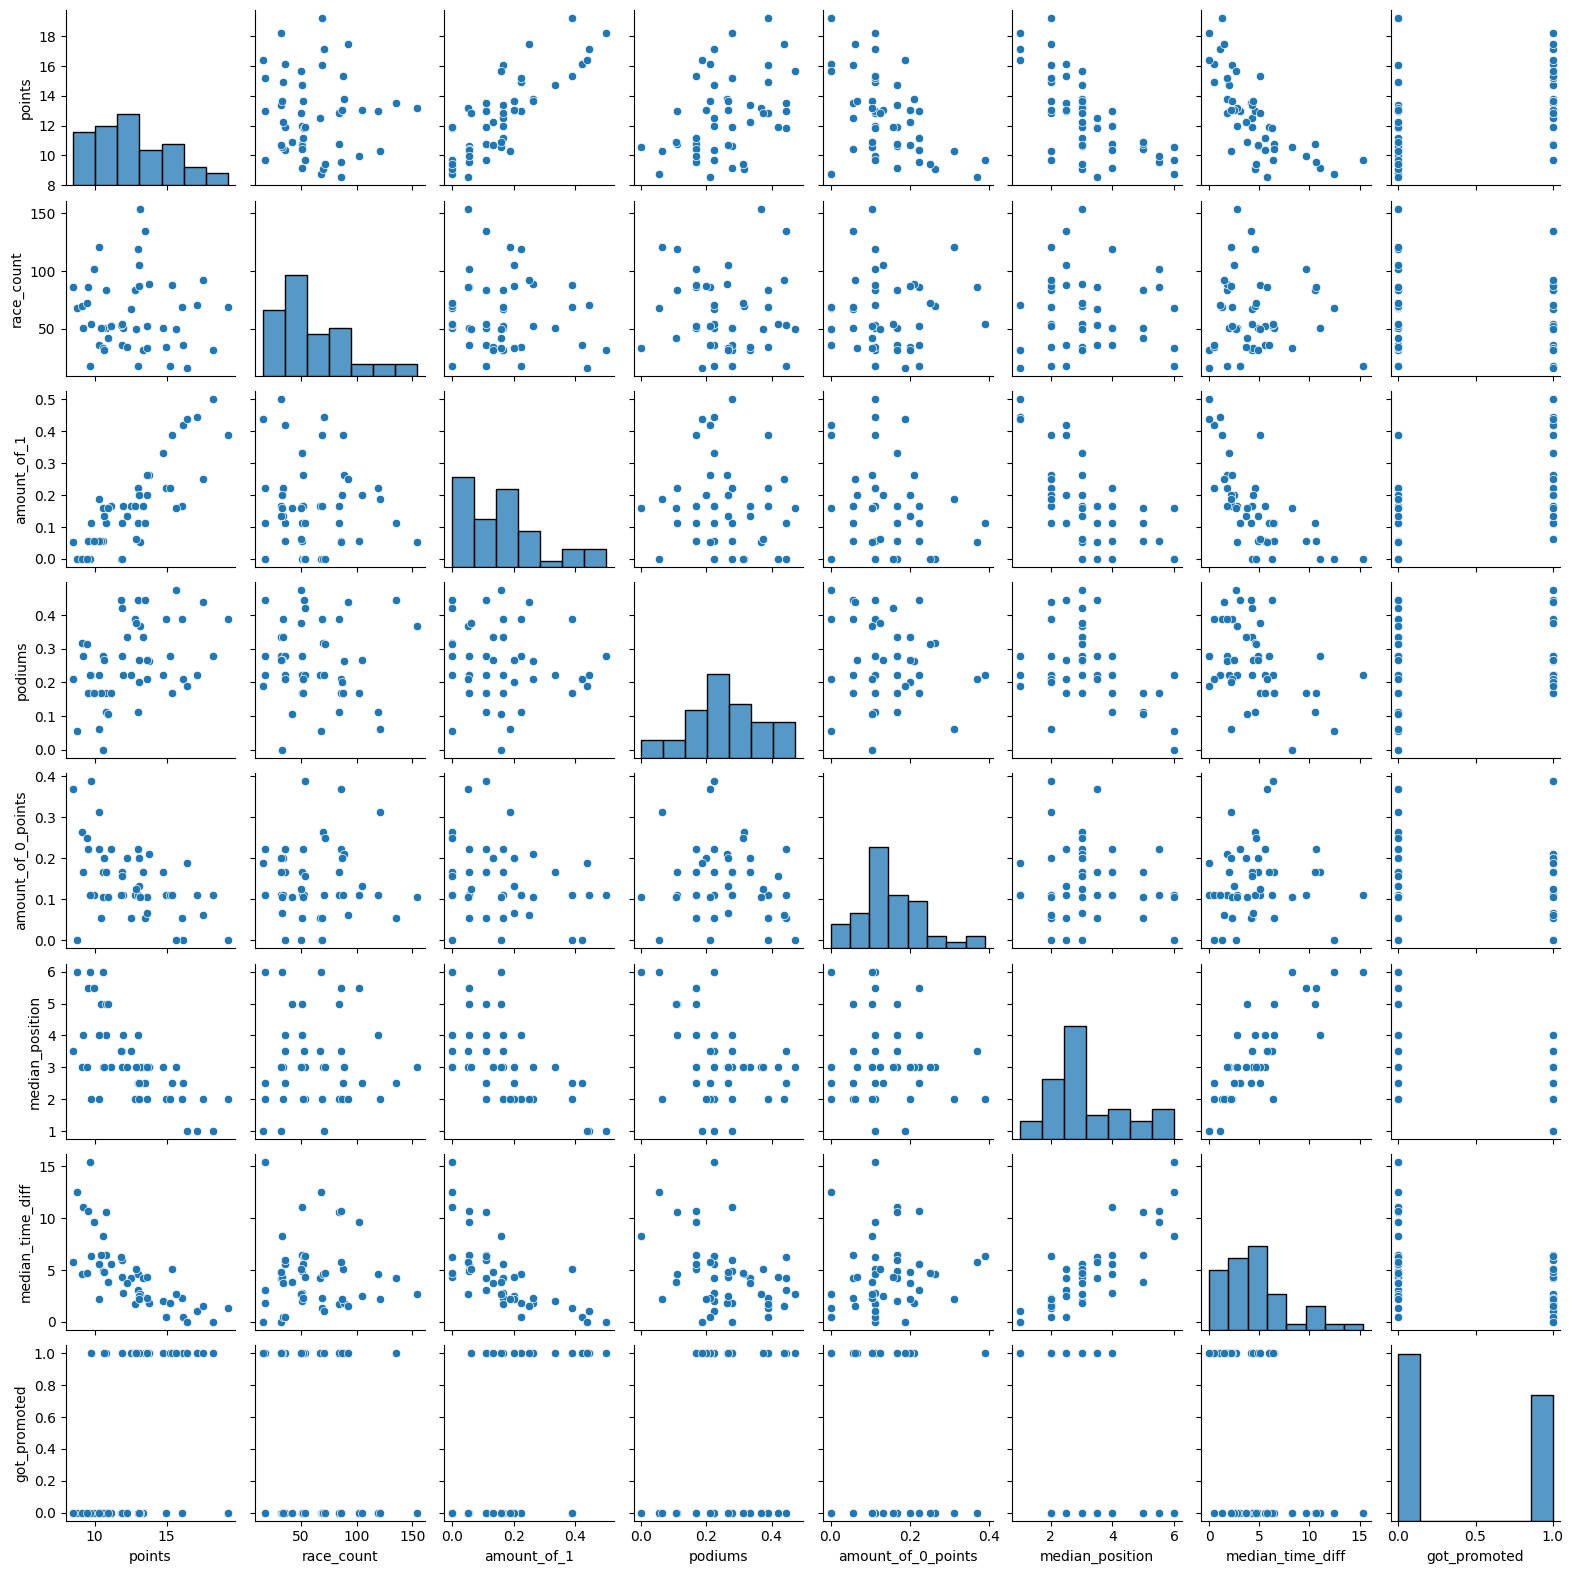

In [11]:
promotion_data = gp.gotPromotionToMotoGP(
    data, season_start=2012, season_end=2022, riders_amount=5
)
promotion_data = promotion_data.drop(
    promotion_data[
        (promotion_data["rider_name"] == "Rabat Tito_2014")
        | (promotion_data["rider_name"] == "Zarco, Johann_2015")
    ].index
)

race_amount_by_year = (
    data[data["category"] == "Moto2"].groupby("year")["sequence"].max().reset_index()
)

promotion_data = promotion_data.merge(race_amount_by_year, on="year", how="left")

promotion_data["points"] = promotion_data["points"] / promotion_data["sequence"]
promotion_data["amount_of_2"] = (
    promotion_data["amount_of_2"] + promotion_data["amount_of_3"]
) / promotion_data["sequence"]
promotion_data["amount_of_1"] = (
    promotion_data["amount_of_1"] / promotion_data["sequence"]
)
promotion_data["amount_of_0_points"] = (
    promotion_data["amount_of_0_points"] / promotion_data["sequence"]
)

promotion_data = promotion_data.rename(columns={"amount_of_2": "podiums"})

promotion_data = promotion_data.drop(
    columns=["sequence", "rider_name", "year", "amount_of_3"]
)

sns.pairplot(promotion_data, height=2)

plt.show()

As we can see, there are quite a few outliers and heteroscedasticity between some variables. It may be wise to use non-parametric correlation methods in addition to Pearson's correlation and compare the results.

Let's plot histograms for all classes of variables to further examine how far their distribution deviates from normality.

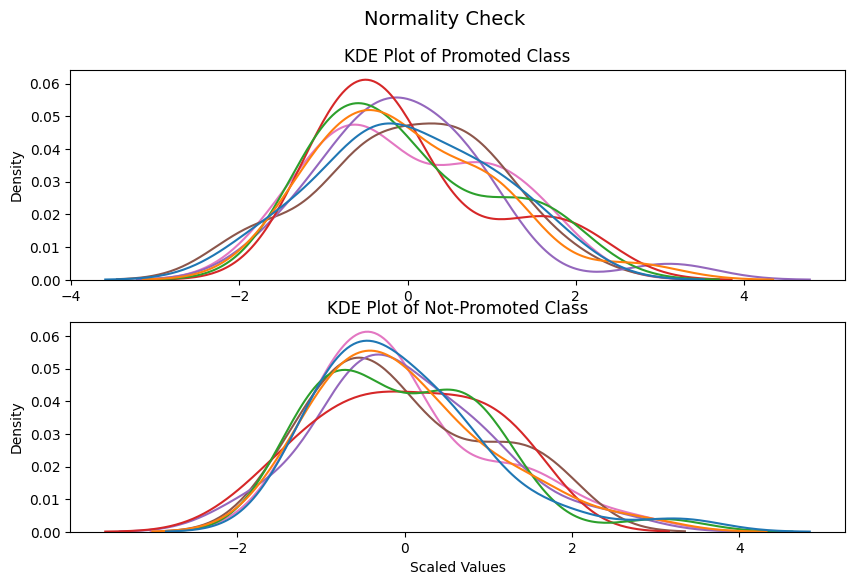

In [12]:
scaler = StandardScaler()

got_promoted_data = scaler.fit_transform(
    promotion_data[promotion_data["got_promoted"] == 1].drop(columns="got_promoted")
)
not_promoted_data = scaler.fit_transform(
    promotion_data[promotion_data["got_promoted"] == 0].drop(columns="got_promoted")
)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.kdeplot(got_promoted_data, legend=False, ax=ax[0])
sns.kdeplot(not_promoted_data, legend=False, ax=ax[1])

ax[0].set_title("KDE Plot of Promoted Class")
ax[1].set_title("KDE Plot of Not-Promoted Class")

ax[1].set_xlabel("Scaled Values")
ax[1].set_ylabel("Density")

plt.suptitle("Normality Check", fontsize=14)

plt.show()

As observed, the data is not normally distributed. The distribution displayed in the image is skewed to the right, indicating a longer tail towards higher values.

9. Let's create a correlation matrix to observe how each feature correlates with the dependent variable. We'll use all three correlation methods: Pearson, Spearman, and Kendall correlations to observe how they influence results, considering that our data does not perfectly adhere to the assumptions of Pearson's correlation.

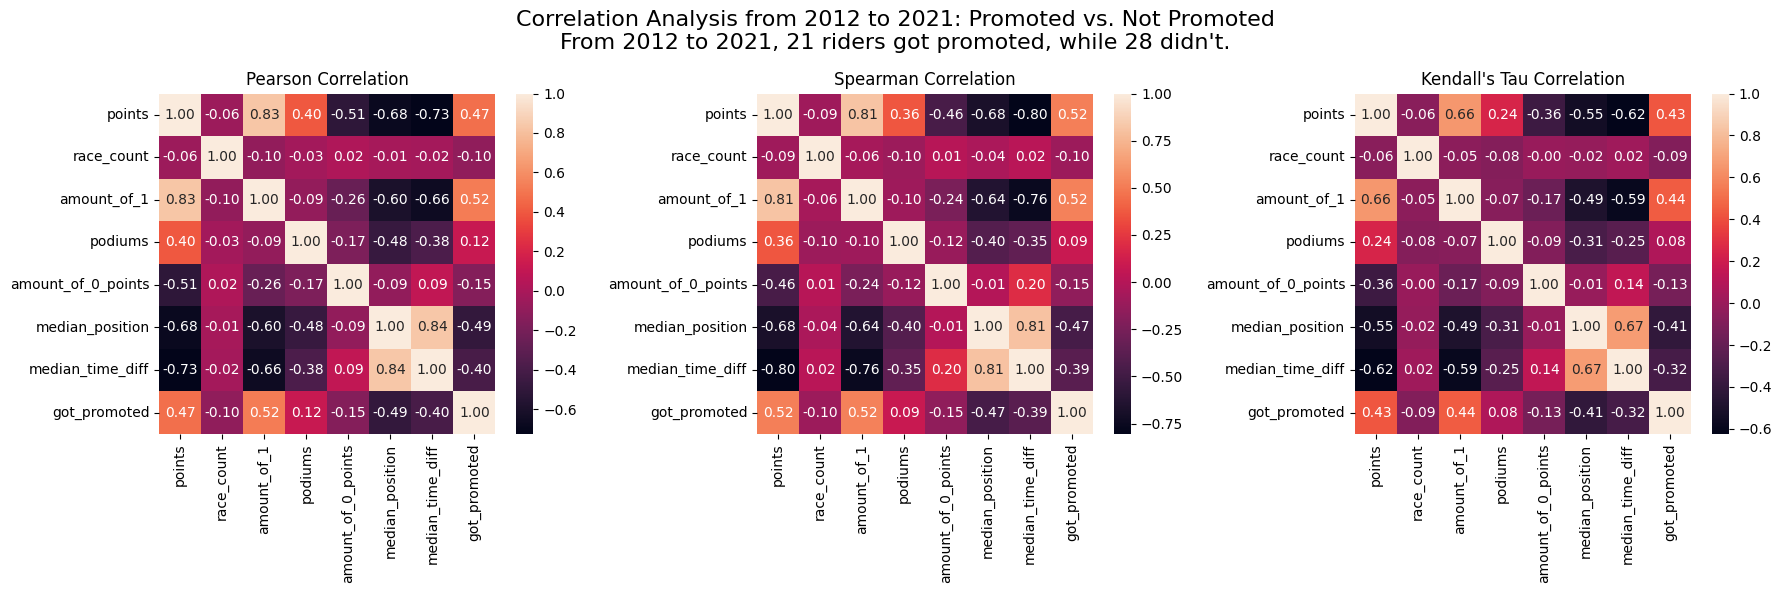

In [13]:
pearson_corr = promotion_data.corr(method="pearson")
spearman_corr = promotion_data.corr(method="spearman")
kendall_tau_corr = promotion_data.corr(method="kendall")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(pearson_corr, annot=True, annot_kws={"fontsize": 10}, fmt=".2f", ax=axes[0])
axes[0].set_title("Pearson Correlation")

sns.heatmap(
    spearman_corr, annot=True, annot_kws={"fontsize": 10}, fmt=".2f", ax=axes[1]
)
axes[1].set_title("Spearman Correlation")

sns.heatmap(
    kendall_tau_corr, annot=True, annot_kws={"fontsize": 10}, fmt=".2f", ax=axes[2]
)
axes[2].set_title("Kendall's Tau Correlation")

plt.suptitle(
    f"Correlation Analysis from 2012 to 2021: Promoted vs. Not Promoted\nFrom 2012 to 2021, {promotion_data['got_promoted'].value_counts()[1]} riders got promoted, while {promotion_data['got_promoted'].value_counts()[0]} didn't.",
    fontsize=16,
)

plt.tight_layout()

plt.show()

According to the correlation matrix, it appears that "amount_of_1" and "median_position" correlate more strongly with the dependent variable than "points" in the championship and "median_time_diff" accordingly. Across the three different correlation methods, the results are roughly the same. However, Spearman correlation shows that "amount_of_1" correlates with the dependent variable similar to "points", while in Kendall's tau, this correlation differs only by 0.01.

As expected, "race_count" exhibits a negative correlation, which adds credibility to the hypothesis that fewer races increase the chances for promotion. However, the correlation is very weak. For instance, "amount_of_0" also demonstrates a weak negative correlation, albeit stronger than "race_count." Naturally, "median_position" and "median_time_diff" also display negative correlations, but this is due to the fact that lower values indicate a greater chance of getting promoted, and vice versa.

10. Let's conduct two feature selection tests as alternatives to the correlation matrix: one parametric ANOVA F-classification test and one non-parametric mutual information classification test. We'll use these tests to assess feature importance and identify the most relevant features for our analysis.

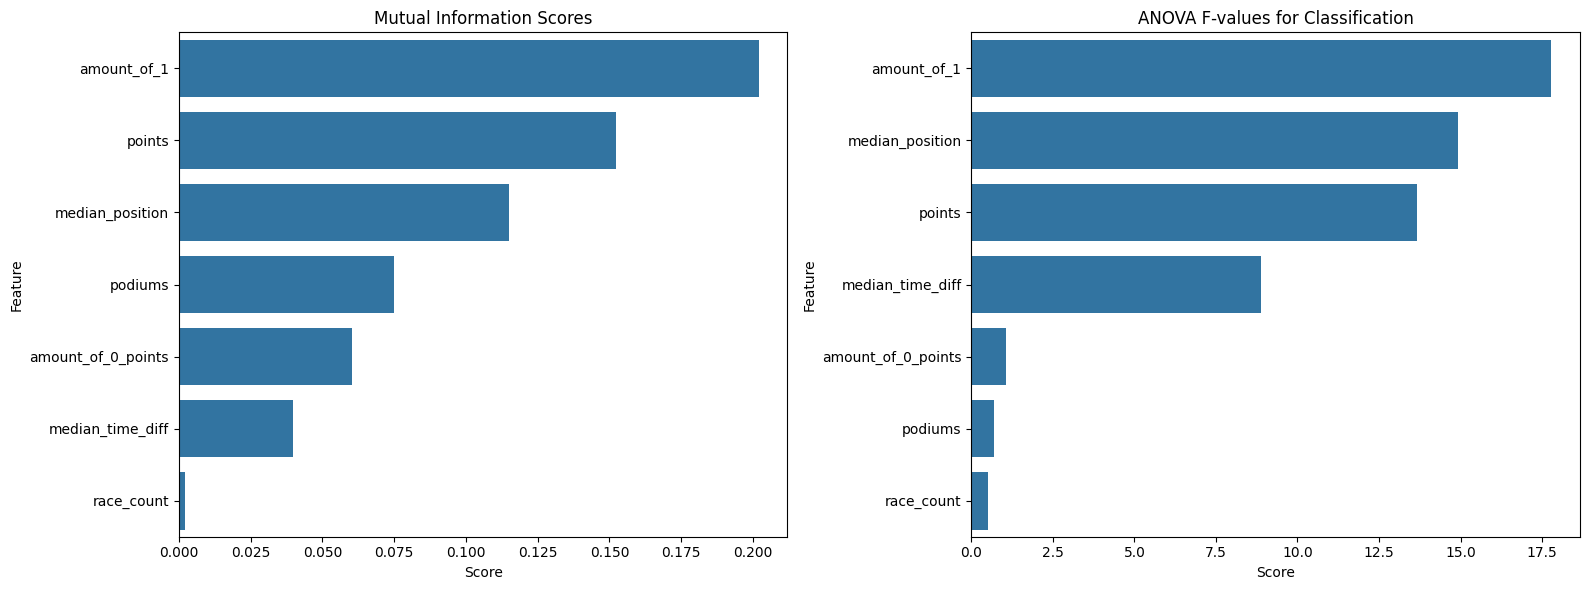

In [14]:
y = promotion_data["got_promoted"]
x = promotion_data.drop(columns=["got_promoted"])

best_features_mi_scores = np.zeros((50, len(x.columns)))

for i in range(50):
    best_features_mi = GenericUnivariateSelect(
        score_func=mutual_info_classif, mode="k_best", param="all"
    )
    features_mi = best_features_mi.fit_transform(x, y)
    best_features_mi_scores[i] = best_features_mi.scores_

mean_scores_mi = np.mean(best_features_mi_scores, axis=0)

best_features_f = GenericUnivariateSelect(
    score_func=f_classif, mode="k_best", param="all"
)
features_f = best_features_f.fit_transform(x, y)

feature_scores_mi = pd.DataFrame({"Feature": x.columns, "Score": mean_scores_mi})

feature_scores_f = pd.DataFrame(
    {"Feature": x.columns, "Score": best_features_f.scores_}
)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=feature_scores_mi.sort_values(by="Score", ascending=False),
    x="Score",
    y="Feature",
    ax=ax[0],
    orient="h",
)
ax[0].set_title("Mutual Information Scores")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Feature")

sns.barplot(
    data=feature_scores_f.sort_values(by="Score", ascending=False),
    x="Score",
    y="Feature",
    ax=ax[1],
    orient="h",
)
ax[1].set_title("ANOVA F-values for Classification")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

It should be emphasized once again that mutual information scores are more suitable for our data. Due to its nature, mutual information scores may show different results over consecutive runs. However, most often we will see results that are not significantly different from what we observed in the correlation matrix. "amount_of_1" seems to be preferable over "points", as well as "median_position" being more important than "median_time_diff". The same results can be observed in the ANOVA test.

11. Continuing with feature importance, we'll employ tree-based classification, opting for random forest classification as our non-parametric test. This approach allows us to assess the significance of each feature in predicting promotions within the Moto2 dataset. We'll categorize the features into five groups. The zero group will retain all available features. In the first group, we'll exclude "points" and "median_time_diff", while the second group will exclude "points" and "median_position". Similarly, the third group will omit "amount_of_1" and "median_time_diff", and the fourth group will exclude "amount_of_1" and "median_position".

Next, we'll compare several metrics across these groups, including ROC AUC, accuracy, F1 score, and recall. Given that our objective is to determine who gets promoted, distinguishing true positives is the goal. Consequently, F1 score and recall will serve as our primary metrics.

Considering the dataset's imbalance, we'll utilize Stratified KFold Shuffle Split for cross-validation and employ the SMOTE technique to enhance representation of the minority class.

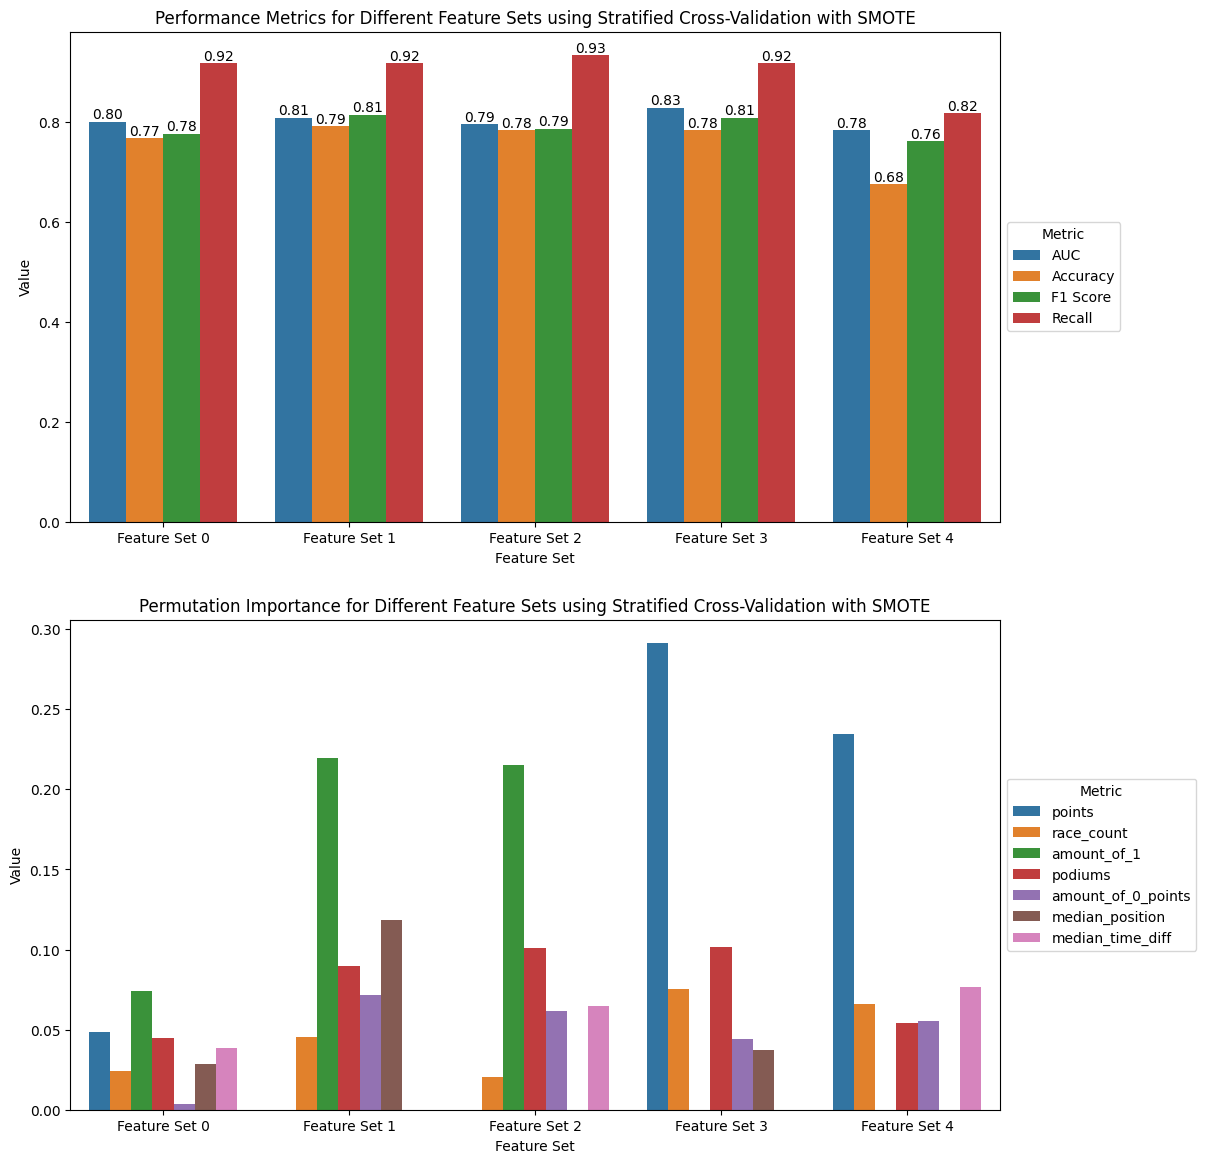

In [17]:
y = promotion_data.loc[:, "got_promoted"]
x = promotion_data.drop(columns=["got_promoted"])
x1 = promotion_data.drop(columns=["points", "median_time_diff", "got_promoted"])
x2 = promotion_data.drop(columns=["points", "median_position", "got_promoted"])
x3 = promotion_data.drop(columns=["amount_of_1", "median_time_diff", "got_promoted"])
x4 = promotion_data.drop(columns=["amount_of_1", "median_position", "got_promoted"])

feature_sets = [x, x1, x2, x3, x4]

classifier = RandomForestClassifier()

results = []
permutations = []

stratified_cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)

for i, features in enumerate(feature_sets):
    features_resampled, y_resampled = smote.fit_resample(features, y)

    auc_scores = cross_val_score(
        classifier, features_resampled, y_resampled, cv=stratified_cv, scoring="roc_auc"
    )
    accuracy = cross_val_score(
        classifier,
        features_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring="accuracy",
    )
    recall = cross_val_score(
        classifier, features_resampled, y_resampled, cv=stratified_cv, scoring="recall"
    )
    f1 = cross_val_score(
        classifier, features_resampled, y_resampled, cv=stratified_cv, scoring="f1"
    )

    classifier.fit(features_resampled, y_resampled)

    results_permutation = permutation_importance(
        classifier, features_resampled, y_resampled, scoring="f1"
    )
    feature_importances = results_permutation.importances_mean

    results.append(
        {
            "Feature Set": f"Feature Set {i}",
            "AUC": np.mean(auc_scores),
            "Accuracy": np.mean(accuracy),
            "F1 Score": np.mean(f1),
            "Recall": np.mean(recall),
        }
    )
    permutations.append(
        {
            "Feature Set": f"Feature Set {i}",
            "Permutation Importance": dict(zip(features, feature_importances)),
        }
    )

results_df = pd.DataFrame(results)
results_melted = results_df.melt(
    id_vars=["Feature Set"], var_name="Metric", value_name="Value"
)
permutations_df = pd.DataFrame(permutations)
permutations_df = pd.concat(
    [
        permutations_df["Feature Set"],
        pd.DataFrame(permutations_df["Permutation Importance"].tolist()),
    ],
    axis=1,
).fillna(0)
permutations_melted_df = permutations_df.melt(
    id_vars=["Feature Set"], var_name="Feature", value_name="Value"
)

fig, ax = plt.subplots(2, 1, figsize=(12, 14))

sns.barplot(data=results_melted, x="Feature Set", y="Value", hue="Metric", ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container, fmt="%.2f", fontsize=10)
ax[0].set_title(
    "Performance Metrics for Different Feature Sets using Stratified Cross-Validation with SMOTE"
)
ax[0].legend(title="Metric", loc="center left", bbox_to_anchor=(1, 0.5))

sns.barplot(
    data=permutations_melted_df, x="Feature Set", y="Value", hue="Feature", ax=ax[1]
)
ax[1].set_title(
    "Permutation Importance for Different Feature Sets using Stratified Cross-Validation with SMOTE"
)
ax[1].legend(title="Metric", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

Over many runs, it's evident that Feature Sets 1 and 2 perform the best, although the difference is not very significant. Generally, Feature Set 4 tends to perform the worst. We observe that Feature Sets containing "median_position" instead of "median_time_diff" typically perform better. The difference between "amount_of_1" and "points" is negligible across the different sets. However, in Feature Set 0, which includes all features, "amount_of_1" shows slightly greater importance than "points". The same observation applies to the pair "median_position" and "median_time_diff". In summary, the most influential factor is "median_position", especially when paired with "points". It's clear that "median_position" performs much better than "median_time_diff" when combined with "points", as seen in Feature Set 4.

12. Let's employ another tree-based classification, this time using a parametric approach. Despite our data not being perfectly normally distributed, it still resembles a bell curve to some extent. Therefore, it makes sense to try Gaussian Naive Bayes. This test should work nicely with normalized data.

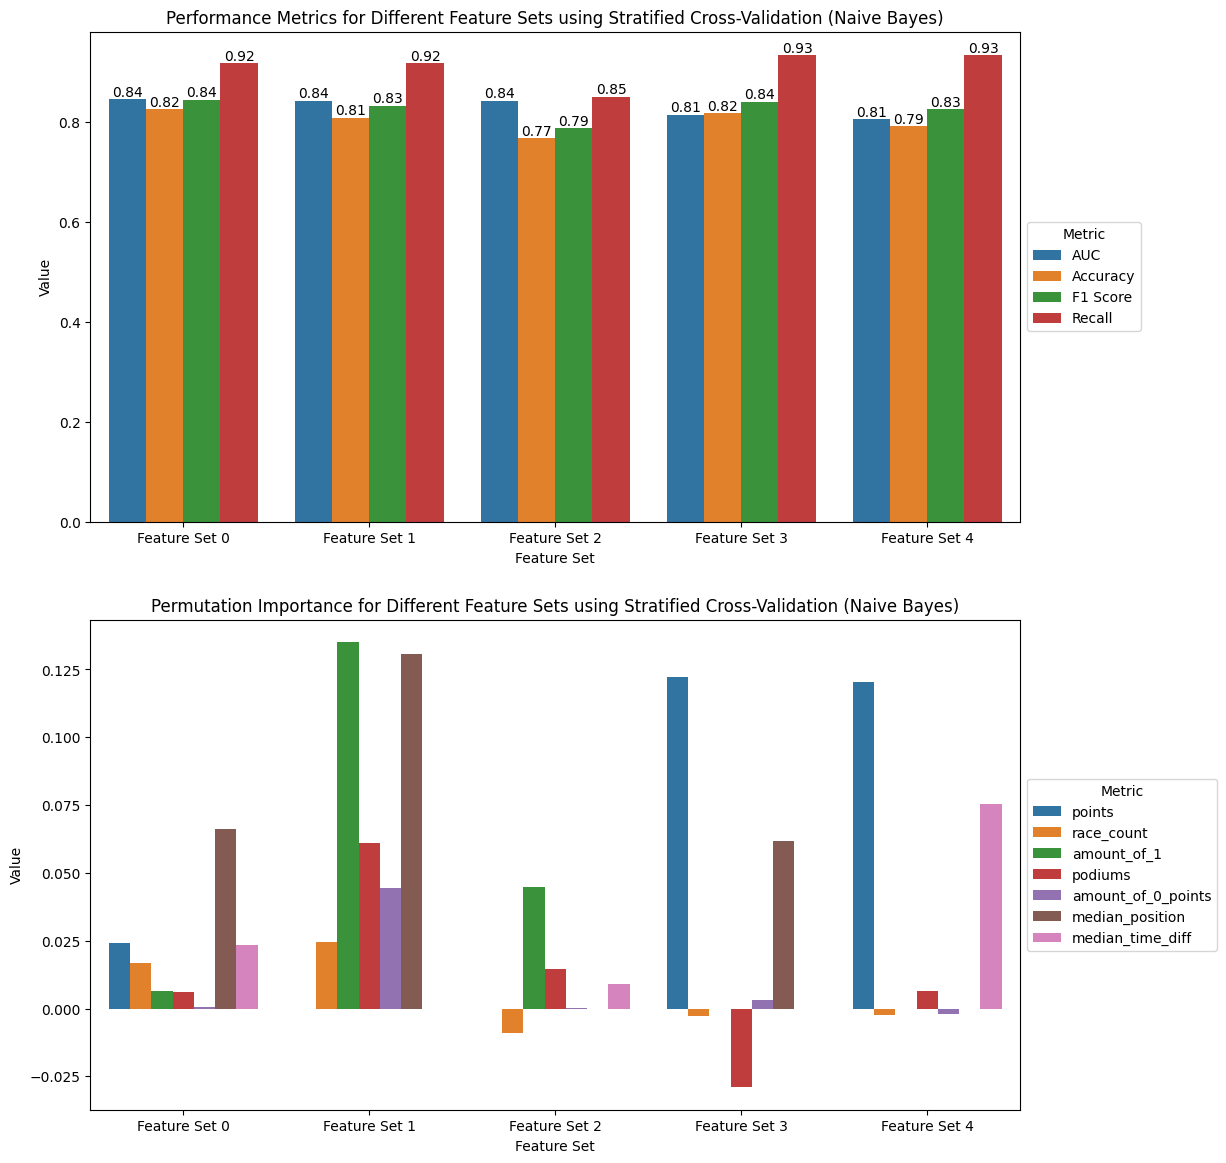

In [18]:
scaler = StandardScaler()

x_scaled = scaler.fit_transform(x)
x1_scaled = scaler.fit_transform(x1)
x2_scaled = scaler.fit_transform(x2)
x3_scaled = scaler.fit_transform(x3)
x4_scaled = scaler.fit_transform(x4)

feature_unscaled = [x, x1, x2, x3, x4]
feature_sets = [x_scaled, x1_scaled, x2_scaled, x3_scaled, x4_scaled]

naive_classifier = GaussianNB()

results = []
permutations = []

stratified_cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)

for i, features in enumerate(feature_sets):
    features_resampled, y_resampled = smote.fit_resample(features, y)

    auc_scores = cross_val_score(
        naive_classifier,
        features_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring="roc_auc",
    )
    accuracy = cross_val_score(
        naive_classifier,
        features_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring="accuracy",
    )
    recall = cross_val_score(
        naive_classifier,
        features_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring="recall",
    )
    f1 = cross_val_score(
        naive_classifier,
        features_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring="f1",
    )

    naive_classifier.fit(features_resampled, y_resampled)

    results_permutation = permutation_importance(
        naive_classifier, features_resampled, y_resampled, scoring="f1"
    )
    feature_importances = results_permutation.importances_mean

    results.append(
        {
            "Feature Set": f"Feature Set {i}",
            "AUC": np.mean(auc_scores),
            "Accuracy": np.mean(accuracy),
            "F1 Score": np.mean(f1),
            "Recall": np.mean(recall),
        }
    )

    permutations.append(
        {
            "Feature Set": f"Feature Set {i}",
            "Permutation Importance": dict(
                zip(feature_unscaled[i].columns.tolist(), feature_importances)
            ),
        }
    )

results_df = pd.DataFrame(results)
results_melted = results_df.melt(
    id_vars=["Feature Set"], var_name="Metric", value_name="Value"
)
permutations_df = pd.DataFrame(permutations)
permutations_df = pd.concat(
    [
        permutations_df["Feature Set"],
        pd.DataFrame(permutations_df["Permutation Importance"].tolist()),
    ],
    axis=1,
)
permutations_melted_df = permutations_df.melt(
    id_vars=["Feature Set"], var_name="Feature", value_name="Value"
)

fig, ax = plt.subplots(2, 1, figsize=(12, 14))

sns.barplot(data=results_melted, x="Feature Set", y="Value", hue="Metric", ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container, fmt="%.2f", fontsize=10)
ax[0].set_title(
    "Performance Metrics for Different Feature Sets using Stratified Cross-Validation (Naive Bayes)"
)
ax[0].legend(title="Metric", loc="center left", bbox_to_anchor=(1, 0.5))

sns.barplot(
    data=permutations_melted_df, x="Feature Set", y="Value", hue="Feature", ax=ax[1]
)
ax[1].set_title(
    "Permutation Importance for Different Feature Sets using Stratified Cross-Validation (Naive Bayes)"
)
ax[1].legend(title="Metric", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

Surprisingly, the parametric Gaussian Naive Bayes test yields very similar results. However, now it appears that "points" are more important than "amount_of_1". For "median_position", the results remain consistent, with feature sets containing it outperforming those with "median_time_diff". Nevertheless, the results are still very close. In the feature set with all features included, "points" and "amount_of_1" often lose their importance, and "median_position" emerges as the most crucial feature.

In summary, achieving a favorable median position may emerge as the pivotal factor in securing a rider's promotion. This is particularly pertinent for young riders with limited race experience, where the ability to swiftly adapt and demonstrate promising results holds significant value for MotoGP teams. While claiming the most victories and clinching the Moto2 Championship with the highest points tally traditionally serves as the direct path to MotoGP, it's important to recognize that immediate competitiveness can also propel a rider into MotoGP, even without securing the championship title in Moto2.